Assignment 2 - Convolution Networks to image data

Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving dogs-vs-cats.zip to dogs-vs-cats.zip


Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.
Saving dogs-vs-cats.zip to dogs-vs-cats.zip

In [2]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?



In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


# Training has 1000 samples, test has 500 samples and validation has 500 samples.

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Data Preprocessing

Data Preprocessing An integral step in machine learning as the quality of the data and the useful information that can be derived from it directly affects the ability of our model to learn. 1.Read the pictures 2.Convert JPEG content into RGB grid of pixels

Convert RGB grid of pixels into floating point tensors Resize them Make them into batches

Using image_dataset_from_directory to read images

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Create a dataset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16

In [5]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [6]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


(16,)
(16,)
(16,)
Batch size of 32

In [7]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


(4, 4)
(4, 4)
(4, 4)
Displaying the shapes of the data and labels yielded by the Dataset



In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
Building the model

Instantiating a small convnet for dogs vs. cats classification

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Configuring the model for training

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

After compiling the model, we train it on the training dataset, validating the results at the end of each epoch with the validation dataset. I'm making use of GPU to reduce the amount of time each epoch takes in execution.

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Fitting the model using a Dataset

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 6s 92ms/step - loss: 0.6725 - accuracy: 0.6030 - val_loss: 0.6656 - val_accuracy: 0.6010
Epoch 2/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6421 - accuracy: 0.6540 - val_loss: 0.6609 - val_accuracy: 0.6240
Epoch 3/30
63/63 [==============================] - 4s 52ms/step - loss: 0.6330 - accuracy: 0.6550 - val_loss: 0.6536 - val_accuracy: 0.6240
Epoch 4/30
63/63 [==============================] - 3s 44ms/step - loss: 0.5999 - accuracy: 0.6870 - val_loss: 0.6037 - val_accuracy: 0.6720
Epoch 5/30
63/63 [==============================] - 3s 47ms/step - loss: 0.5674 - accuracy: 0.7035 - val_loss: 0.5846 - val_accuracy: 0.6900
Epoch 6/30
63/63 [==============================] - 3s 45ms/step - loss: 0.5219 - accuracy: 0.7305 - val_loss: 0.5873 - val_accuracy: 0.6980
Epoch 7/30
63/63 [==============================] - 3s 48ms/step - loss: 0.4826 - accuracy: 0.7635 - val_loss: 0.5663 - val_accuracy: 0.6990
Epoch 8/30
63

Evaluating the model on the test set

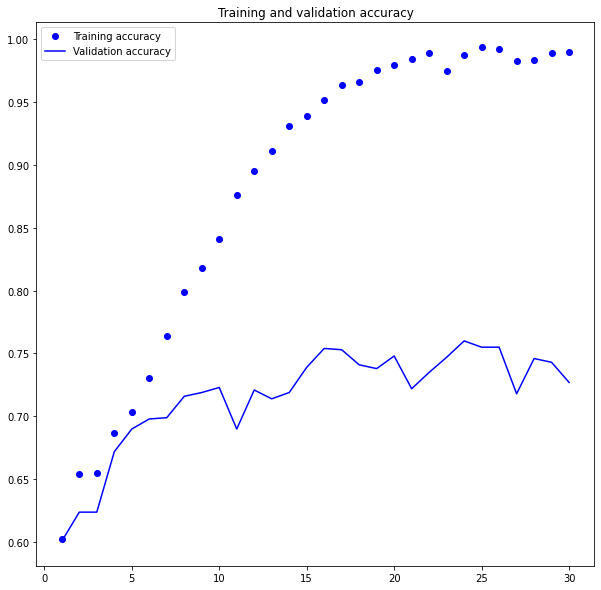

<Figure size 432x288 with 0 Axes>

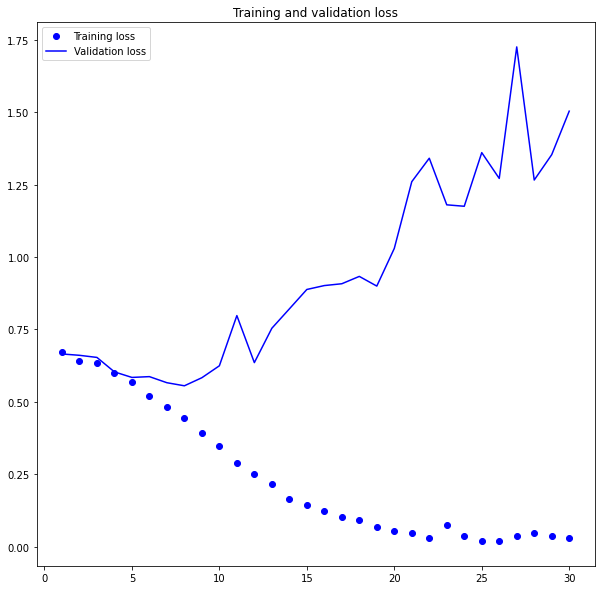

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 56ms/step - loss: 0.5628 - accuracy: 0.7280
Test accuracy: 0.728


Increase your training sample size. You may pick any amount. Keep the validation and test
samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

Define a data augmentation stage to add to an image model

In [20]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1800)
make_subset("validation", start_index=1800, end_index=2300)
make_subset("test", start_index=2300, end_index=2800)

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

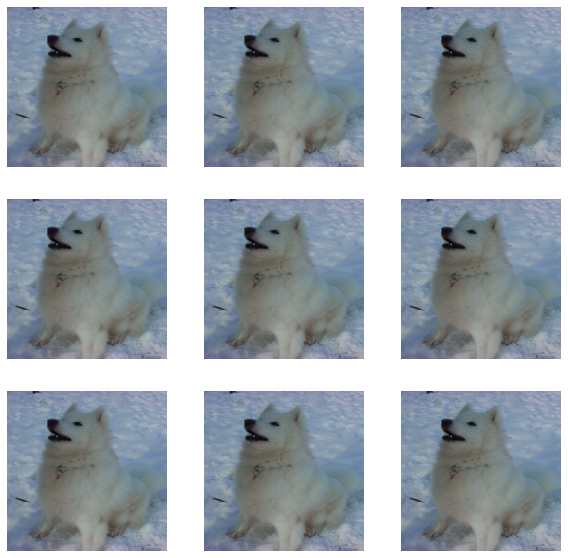

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=5, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Training the regularized convnet



In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 124ms/step - loss: 0.7100 - accuracy: 0.5165 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 12s 172ms/step - loss: 0.6938 - accuracy: 0.5020 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 11s 167ms/step - loss: 0.6915 - accuracy: 0.5025 - val_loss: 0.6822 - val_accuracy: 0.5700
Epoch 4/50
63/63 [==============================] - 13s 191ms/step - loss: 0.6886 - accuracy: 0.5425 - val_loss: 0.6925 - val_accuracy: 0.5070
Epoch 5/50
63/63 [==============================] - 9s 136ms/step - loss: 0.6877 - accuracy: 0.5415 - val_loss: 0.6871 - val_accuracy: 0.5470
Epoch 6/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6913 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 7/50
63/63 [==============================] - 9s 127ms/step - loss: 0.6940 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5010
E

Evaluating the model on the test set

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.6843 - accuracy: 0.5630
Test accuracy: 0.563


3. Now change your training sample so that you achieve better performance than those from Steps
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

In [26]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 1500 samples.
make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=3500)

Defining a new convnet with increased training samples,image augmentation and dropout



In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 10s 139ms/step - loss: 0.7039 - accuracy: 0.5160 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 8s 122ms/step - loss: 0.6893 - accuracy: 0.5245 - val_loss: 0.6900 - val_accuracy: 0.5170
Epoch 3/30
63/63 [==============================] - 9s 125ms/step - loss: 0.6883 - accuracy: 0.5470 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 4/30
63/63 [==============================] - 10s 143ms/step - loss: 0.6877 - accuracy: 0.5385 - val_loss: 0.6923 - val_accuracy: 0.5160
Epoch 5/30
63/63 [==============================] - 12s 174ms/step - loss: 0.6881 - accuracy: 0.5395 - val_loss: 0.6862 - val_accuracy: 0.5510
Epoch 6/30
63/63 [==============================] - 12s 169ms/step - loss: 0.6872 - accuracy: 0.5310 - val_loss: 0.6719 - val_accuracy: 0.5790
Epoch 7/30
63/63 [==============================] - 11s 167ms/step - loss: 0.6712 - accuracy: 0.5930 - val_loss: 0.6618 - val_accuracy: 0.5870
E

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 92ms/step - loss: 0.5064 - accuracy: 0.7700
Test accuracy: 0.770


4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3
for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Instantiating the VGG16 convolutional base

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Feature extraction without data augmentation using a pretrained model

Extracting the VGG16 features and corresponding labels

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 1s 8ms/step - loss: 11.3083 - accuracy: 0.9290 - val_loss: 4.5797 - val_accuracy: 0.9610
Epoch 2/30
63/63 [==============================] - 0s 6ms/step - loss: 3.1163 - accuracy: 0.9775 - val_loss: 2.9685 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 0s 4ms/step - loss: 3.9856 - accuracy: 0.9740 - val_loss: 5.3290 - val_accuracy: 0.9700
Epoch 4/30
63/63 [==============================] - 0s 4ms/step - loss: 0.8816 - accuracy: 0.9920 - val_loss: 3.5406 - val_accuracy: 0.9750
Epoch 5/30
63/63 [==============================] - 0s 4ms/step - loss: 1.3326 - accuracy: 0.9920 - val_loss: 4.1497 - val_accuracy: 0.9720
Epoch 6/30
63/63 [==============================] - 0s 4ms/step - loss: 0.1936 - accuracy: 0.9970 - val_loss: 3.9076 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 0s 4ms/step - loss: 1.6469 - accuracy: 0.9905 - val_loss: 5.2217 - val_accuracy: 0.9770
Epoch 8/30
63/63 [=

Plotting the results

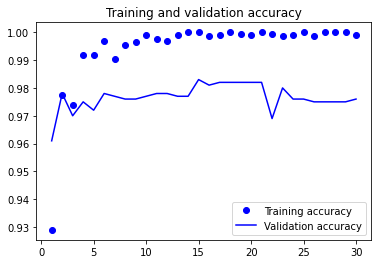

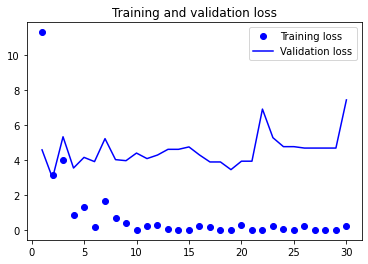

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Instantiating and freezing the VGG16 convolutional base

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing

In [37]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
63/63 [==============================] - 5s 53ms/step - loss: 23.0098 - accuracy: 0.8900 - val_loss: 4.2878 - val_accuracy: 0.9680
Epoch 2/40
63/63 [==============================] - 3s 47ms/step - loss: 7.8582 - accuracy: 0.9440 - val_loss: 6.2896 - val_accuracy: 0.9640
Epoch 3/40
63/63 [==============================] - 3s 50ms/step - loss: 6.8141 - accuracy: 0.9480 - val_loss: 3.9332 - val_accuracy: 0.9770
Epoch 4/40
63/63 [==============================] - 3s 46ms/step - loss: 5.6601 - accuracy: 0.9610 - val_loss: 5.4059 - val_accuracy: 0.9680
Epoch 5/40
63/63 [==============================] - 3s 46ms/step - loss: 3.7532 - accuracy: 0.9685 - val_loss: 5.9474 - val_accuracy: 0.9710
Epoch 6/40
63/63 [==============================] - 3s 48ms/step - loss: 5.2500 - accuracy: 0.9635 - val_loss: 5.3759 - val_accuracy: 0.9680
Epoch 7/40
63/63 [==============================] - 3s 47ms/step - loss: 3.4744 - accuracy: 0.9705 - val_loss: 5.2945 - val_accuracy: 0.9680
Epoch 8/40
6

Evaluating the model on the test set



In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 21ms/step - loss: 2.0549 - accuracy: 0.9770
Test accuracy: 0.977


In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [43]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [44]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 5s 55ms/step - loss: 0.5471 - accuracy: 0.9870 - val_loss: 2.0723 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 3s 49ms/step - loss: 0.3382 - accuracy: 0.9880 - val_loss: 2.0984 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 3s 53ms/step - loss: 0.2702 - accuracy: 0.9890 - val_loss: 1.3227 - val_accuracy: 0.9800
Epoch 4/20
63/63 [==============================] - 3s 49ms/step - loss: 0.3837 - accuracy: 0.9915 - val_loss: 1.6705 - val_accuracy: 0.9740
Epoch 5/20
63/63 [==============================] - 3s 53ms/step - loss: 0.2322 - accuracy: 0.9920 - val_loss: 1.2209 - val_accuracy: 0.9800
Epoch 6/20
63/63 [==============================] - 3s 49ms/step - loss: 0.1948 - accuracy: 0.9920 - val_loss: 1.4404 - val_accuracy: 0.9800
Epoch 7/20
63/63 [==============================] - 3s 50ms/step - loss: 0.4563 - accuracy: 0.9900 - val_loss: 1.2940 - val_accuracy: 0.9750
Epoch 8/20
63

In [45]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 20ms/step - loss: 1.5499 - accuracy: 0.9810
Test accuracy: 0.981
